In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
else:
    print('CUDA is available! Training on GPU...')

CUDA is not available. Training on CPU...


In [ ]:
# Download and load the dataset using kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("swoyam2609/fresh-and-stale-classification")

print("Path to dataset files:", path)

dataset_path = os.path.join(path, "dataset")

Path to dataset files: /root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1


In [ ]:
# Define data directories
train_dir = os.path.join(dataset_path, 'Train')
test_dir = os.path.join(dataset_path, 'Test')

# Get list of classes
Train_classes = os.listdir(train_dir)
Test_classes = os.listdir(test_dir)

print("Train_classes:", Train_classes)
print("Test_classes:", Test_classes)


Train_classes: ['rottenokra', 'rottencucumber', 'rottenpotato', 'freshcucumber', 'freshokra', 'freshbanana', 'rottenbittergroud', 'freshpotato', 'freshoranges', 'freshapples', 'rottenbanana', 'freshbittergroud', 'freshtomato', 'rottenoranges', 'rottenapples', 'rottencapsicum', 'rottentomato', 'freshcapsicum']
Test_classes: ['rottenokra', 'rottencucumber', 'rottenpotato', 'freshcucumber', 'freshokra', 'freshbanana', 'freshpotato', 'freshoranges', 'freshapples', 'rottenbanana', 'freshtomato', 'rottenoranges', 'rottenapples', 'rottentomato']


In [ ]:
# Function to remove corrupted images
def remove_corrupted_images(directory, classes):
    corrupted_count = 0  # Initialize counter for corrupted images
    for cls in classes:
        cls_path = os.path.join(directory, cls)
        images = os.listdir(cls_path)
        for img_name in images:
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Verify that it is, in fact, an image
                img.close()
            except (IOError, SyntaxError, Image.DecompressionBombError):
                print(f"Removing corrupted image: {img_path}")
                os.remove(img_path)
                corrupted_count += 1  # Increment the counter
    print(f"Total corrupted images removed from {directory}: {corrupted_count}")

# Remove corrupted images from train and test sets
remove_corrupted_images(train_dir, Train_classes)
remove_corrupted_images(test_dir, Test_classes)


Total corrupted images removed from /root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset/Train: 0
Total corrupted images removed from /root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset/Test: 0


In [ ]:
# Function to resize images
def resize_images(directory, classes, target_size=(224, 224)):
    for cls in classes:
        cls_path = os.path.join(directory, cls)
        images = os.listdir(cls_path)
        for img_name in images:
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path)
                img = img.resize(target_size)
                img.save(img_path)
                img.close()
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

# Resize images in train and test sets
resize_images(train_dir, Train_classes)
resize_images(test_dir, Test_classes)

In [ ]:
# Correcting typos in test set
corrections = {
    'rottenpatato': 'rottenpotato',
    'rottentamto': 'rottentomato',
    'freshtamto': 'freshtomato',
    'freshpatato': 'freshpotato',
}

# Rename directories with typos
for old_name, new_name in corrections.items():
    old_path = os.path.join(test_dir, old_name)
    new_path = os.path.join(test_dir, new_name)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed: {old_name} -> {new_name}")

# Update Test_classes after corrections
Test_classes = os.listdir(test_dir)
print("Updated Test_classes:", Test_classes)

Updated Test_classes: ['rottenokra', 'rottencucumber', 'rottenpotato', 'freshcucumber', 'freshokra', 'freshbanana', 'freshpotato', 'freshoranges', 'freshapples', 'rottenbanana', 'freshtomato', 'rottenoranges', 'rottenapples', 'rottentomato']


In [ ]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets
train_data_full = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

In [ ]:
# Ensure consistent class indices between training and testing datasets
print("Train Data Class Indices:", train_data_full.class_to_idx)
print("Test Data Class Indices:", test_data.class_to_idx)

# Assign test_data class_to_idx to match train_data_full
test_data.class_to_idx = train_data_full.class_to_idx
test_data.classes = train_data_full.classes

Train Data Class Indices: {'freshapples': 0, 'freshbanana': 1, 'freshbittergroud': 2, 'freshcapsicum': 3, 'freshcucumber': 4, 'freshokra': 5, 'freshoranges': 6, 'freshpotato': 7, 'freshtomato': 8, 'rottenapples': 9, 'rottenbanana': 10, 'rottenbittergroud': 11, 'rottencapsicum': 12, 'rottencucumber': 13, 'rottenokra': 14, 'rottenoranges': 15, 'rottenpotato': 16, 'rottentomato': 17}
Test Data Class Indices: {'freshapples': 0, 'freshbanana': 1, 'freshcucumber': 2, 'freshokra': 3, 'freshoranges': 4, 'freshpotato': 5, 'freshtomato': 6, 'rottenapples': 7, 'rottenbanana': 8, 'rottencucumber': 9, 'rottenokra': 10, 'rottenoranges': 11, 'rottenpotato': 12, 'rottentomato': 13}


In [ ]:
# # Create data loaders
# batch_size = 32
# train_loader = DataLoader(train_data_small, batch_size=batch_size, sampler=train_sampler, num_workers=0)
# valid_loader = DataLoader(train_data_small, batch_size=batch_size, sampler=valid_sampler, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
model = models.resnet18(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_workers = 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, TensorDataset, random_split
from torchvision import transforms, models

# Assuming you have variables: train_data_full, train_on_gpu, num_workers defined

# Define the split ratio, for example 90% training, 10% validation
train_ratio = 0.9
train_len = int(train_ratio * len(train_data_full))
valid_len = len(train_data_full) - train_len

train_subset, valid_subset = random_split(train_data_full, [train_len, valid_len])

# Use a smaller subset for faster feature extraction (optional)
subset_size = int(0.3 * train_len)  # Take 10% of the training subset
train_indices = torch.randperm(train_len)[:subset_size]
train_data_small = Subset(train_subset, train_indices)

val_subset_size = int(0.1 * valid_len)  # Take 10% of the validation subset
val_indices = torch.randperm(valid_len)[:val_subset_size]
valid_data_small = Subset(valid_subset, val_indices)

# Reduce image size and remove heavy augmentations to speed up
img_height, img_width = 64, 64
train_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

valid_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

# Apply transforms to the underlying datasets
# Make sure that the original train_data_full dataset does not have its own transforms set
train_data_full.transform = train_transforms
# The validation subset is drawn from the same dataset, so it shares the same underlying transform
# If you want different transforms for validation, apply them here:
# valid_data_full.transform = valid_transforms (if you had a separate dataset)
# Since we're using a subset of train_data_full, the same transforms apply,
# but you can also manually reassign if needed:
valid_subset.dataset.transform = valid_transforms

# Create DataLoaders for these subsets
batch_size = 16
train_loader_small = DataLoader(train_data_small, batch_size=batch_size, shuffle=True,
                                num_workers=num_workers, pin_memory=True)
valid_loader_small = DataLoader(valid_data_small, batch_size=batch_size, shuffle=False,
                                num_workers=num_workers, pin_memory=True)

# Define a pretrained model and extract features (for example, ResNet18)
model = models.resnet18(pretrained=True)
model.eval()
if train_on_gpu:
    model.cuda()

# Feature extractor: all layers except the final FC layer
feature_extractor = nn.Sequential(*list(model.children())[:-1])
if train_on_gpu:
    feature_extractor.cuda()
feature_extractor.eval()

# Extract features for training data
train_features_list = []
train_labels_list = []
with torch.no_grad():
    for images, labels in train_loader_small:
        if train_on_gpu:
            images = images.cuda()
        feats = feature_extractor(images)
        feats = feats.view(feats.size(0), -1)
        train_features_list.append(feats.cpu())
        train_labels_list.append(labels.cpu())
train_features = torch.cat(train_features_list)
train_labels = torch.cat(train_labels_list)

# Extract features for validation data
valid_features_list = []
valid_labels_list = []
with torch.no_grad():
    for images, labels in valid_loader_small:
        if train_on_gpu:
            images = images.cuda()
        feats = feature_extractor(images)
        feats = feats.view(feats.size(0), -1)
        valid_features_list.append(feats.cpu())
        valid_labels_list.append(labels.cpu())
valid_features = torch.cat(valid_features_list)
valid_labels = torch.cat(valid_labels_list)

# Save extracted features to disk for future reuse
torch.save((train_features, train_labels), 'train_features.pt')
torch.save((valid_features, valid_labels), 'valid_features.pt')

print("Feature extraction complete. Files saved: 'train_features.pt' and 'valid_features.pt'")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Feature extraction complete. Files saved: 'train_features.pt' and 'valid_features.pt'


In [ ]:
num_classes = max(train_labels.max().item(), valid_labels.max().item()) + 1


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Load precomputed features (enable weights_only=True if needed to avoid warnings):
train_features, train_labels = torch.load('train_features.pt', weights_only=False)
valid_features, valid_labels = torch.load('valid_features.pt', weights_only=False)

# Combine all labels to find unique classes
all_labels = torch.cat((train_labels, valid_labels))
unique_labels = torch.unique(all_labels)

# Create a mapping from old labels to new zero-based labels
label_map = {old_label.item(): i for i, old_label in enumerate(unique_labels)}

# Remap train and valid labels
train_labels = torch.tensor([label_map[l.item()] for l in train_labels])
valid_labels = torch.tensor([label_map[l.item()] for l in valid_labels])

# Determine the number of classes
num_classes = len(unique_labels)

# Create datasets and dataloaders from the remapped labels
batch_size = 32
train_dataset = TensorDataset(train_features, train_labels)
valid_dataset = TensorDataset(valid_features, valid_labels)

train_loader_features = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader_features = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Check GPU availability
train_on_gpu = torch.cuda.is_available()

# Define the classifier head after knowing num_classes
feature_dim = train_features.size(1)
classifier = nn.Sequential(
    nn.Linear(feature_dim, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

if train_on_gpu:
    classifier.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Training loop
epochs = 30
valid_loss_min = float('inf')
for epoch in range(1, epochs + 1):
    # Training phase
    classifier.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for feats, labels in train_loader_features:
        if train_on_gpu:
            feats, labels = feats.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = classifier(feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * feats.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    # Validation phase
    classifier.eval()
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0
    with torch.no_grad():
        for feats, labels in valid_loader_features:
            if train_on_gpu:
                feats, labels = feats.cuda(), labels.cuda()
            outputs = classifier(feats)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * feats.size(0)
            _, preds = torch.max(outputs, 1)
            valid_correct += (preds == labels).sum().item()
            valid_total += labels.size(0)

    train_loss /= len(train_loader_features.dataset)
    valid_loss /= len(valid_loader_features.dataset)
    train_acc = 100.0 * train_correct / train_total
    valid_acc = 100.0 * valid_correct / valid_total

    print(f'Epoch: {epoch}/{epochs} '
          f'Train Loss: {train_loss:.4f} Valid Loss: {valid_loss:.4f} '
          f'Train Acc: {train_acc:.2f}% Valid Acc: {valid_acc:.2f}%')

    if valid_loss < valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.4f} --> {valid_loss:.4f}). Saving model ...')
        torch.save(classifier.state_dict(), 'best_classifier.pt')
        valid_loss_min = valid_loss


Epoch: 1/30 Train Loss: 1.0317 Valid Loss: 0.4699 Train Acc: 65.99% Valid Acc: 84.32%
Validation loss decreased (inf --> 0.4699). Saving model ...
Epoch: 2/30 Train Loss: 0.5631 Valid Loss: 0.4490 Train Acc: 80.32% Valid Acc: 86.02%
Validation loss decreased (0.4699 --> 0.4490). Saving model ...
Epoch: 3/30 Train Loss: 0.4571 Valid Loss: 0.3348 Train Acc: 83.38% Valid Acc: 87.71%
Validation loss decreased (0.4490 --> 0.3348). Saving model ...
Epoch: 4/30 Train Loss: 0.3993 Valid Loss: 0.3220 Train Acc: 85.49% Valid Acc: 89.83%
Validation loss decreased (0.3348 --> 0.3220). Saving model ...
Epoch: 5/30 Train Loss: 0.3503 Valid Loss: 0.3249 Train Acc: 86.67% Valid Acc: 87.29%
Epoch: 6/30 Train Loss: 0.3188 Valid Loss: 0.2392 Train Acc: 87.88% Valid Acc: 90.68%
Validation loss decreased (0.3220 --> 0.2392). Saving model ...
Epoch: 7/30 Train Loss: 0.3150 Valid Loss: 0.2678 Train Acc: 87.96% Valid Acc: 91.10%
Epoch: 8/30 Train Loss: 0.2856 Valid Loss: 0.2325 Train Acc: 89.18% Valid Acc: 92

In [ ]:
# Assume feature_extractor is defined as before, e.g.:
# feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])
# feature_extractor.eval()
if train_on_gpu:
    feature_extractor.cuda()

# Load the best classifier weights saved during training
classifier.load_state_dict(torch.load('best_classifier.pt'))
classifier.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # Extract features from raw test images
        feats = feature_extractor(images)
        feats = feats.view(feats.size(0), -1)

        # Get predictions from classifier
        outputs = classifier(feats)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * feats.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Loss: {test_loss:.4f} \tTest Accuracy: {test_accuracy:.2f}%')

# Function to predict a single image
def predict_single_image(image, feature_extractor, classifier, train_on_gpu=True):
    classifier.eval()
    feature_extractor.eval()
    with torch.no_grad():
        if train_on_gpu:
            image = image.cuda()
        # Add batch dimension and extract features
        feats = feature_extractor(image.unsqueeze(0))
        feats = feats.view(feats.size(0), -1)
        # Predict
        outputs = classifier(feats)
        _, pred = torch.max(outputs, 1)
        return pred.item()

# Example usage:
# single_image, _ = next(iter(test_loader)) # Take one batch and select first image
# predicted_class = predict_single_image(single_image[0], feature_extractor, classifier, train_on_gpu)
# print("Predicted class index:", predicted_class)


<ipython-input-32-a341023b1543>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load('best_classifier.pt'))


Test Loss: 7.4013 	Test Accuracy: 25.42%


<ipython-input-33-efa64a977263>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load('best_classifier.pt'))


Predicted Class Index: 0
Predicted Class: freshapples
True Class: freshapples


<Figure size 400x400 with 0 Axes>

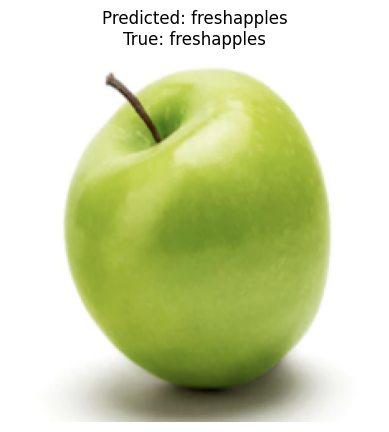

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, TensorDataset, random_split
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np

# Define your class names if available
# If using torchvision.datasets.ImageFolder, you can get class names from train_data_full.classes
# Otherwise, define them manually as a list
# Example:
# class_names = ['class0', 'class1', 'class2', ..., 'classN']
class_names = train_data_full.classes  # Adjust based on your dataset

# Function to unnormalize and display an image
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    # Assuming the image is unnormalized; adjust if you have normalization
    image = image.numpy().transpose((1, 2, 0))
    # If images were normalized, unnormalize them here
    # Example for ImageNet normalization:
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # image = std * image + mean
    image = np.clip(image, 0, 1)  # Clip to valid range
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')
    return ax

# Function to predict a single image
def predict_single_image(image, feature_extractor, classifier, train_on_gpu=True):
    classifier.eval()
    feature_extractor.eval()
    with torch.no_grad():
        if train_on_gpu:
            image = image.cuda()
        # Add batch dimension and extract features
        feats = feature_extractor(image.unsqueeze(0))
        feats = feats.view(feats.size(0), -1)
        # Predict
        outputs = classifier(feats)
        _, pred = torch.max(outputs, 1)
        return pred.item()

# Load the best classifier weights saved during training
classifier.load_state_dict(torch.load('best_classifier.pt'))
classifier.eval()

# Define or load the feature_extractor
# Make sure it's the same as used during training
# Example using ResNet18:
feature_extractor = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-1])
feature_extractor.eval()
if train_on_gpu:
    feature_extractor.cuda()

# Ensure the classifier is on the correct device
if train_on_gpu:
    classifier.cuda()

# Get one batch of test images and labels
test_images, test_labels = next(iter(test_loader))

# Select the first image from the batch
single_image = test_images[0]
true_label = test_labels[0].item()

# Predict its class
predicted_class_idx = predict_single_image(single_image, feature_extractor, classifier, train_on_gpu)
predicted_class = class_names[predicted_class_idx]
true_class = class_names[true_label]

print(f'Predicted Class Index: {predicted_class_idx}')
print(f'Predicted Class: {predicted_class}')
print(f'True Class: {true_class}')

# Display the image with predicted and true labels
plt.figure(figsize=(4,4))
imshow(single_image.cpu(), title=f'Predicted: {predicted_class}\nTrue: {true_class}')
plt.show()
